# Example 5.6 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pylab
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import scipy.integrate as integrate
import warnings
warnings.filterwarnings('ignore')
style.use('ggplot')

Lognormal Distributions

We consider a Black-Scholes market model with
$S_{t_i}^k = S_0 \exp\left(-\frac{{\sigma_{i}^k}^2}{2}{t_i}+\sqrt{t_i}{\sigma_{i}^k}X_i^k\right)$ for $i=1$,$k=1,2,3$.
with 

$S_0^1=10$, $S_0^2=9$, $S_0^3=11$, $t_1=1$ 
and 
${\sigma_{i}^k}=1$ for all $i,k$
$$
(X_i^1,X_i^2,X_i^3) \sim \mathcal{N}(0,\Sigma)
$$
for 
$$
\Sigma = 
\begin{pmatrix}
&1 &\rho_{1,2} &\rho_{1,3}\\
&\rho_{1,2} &1  &\rho_{2,3}\\
&\rho_{1,3} &\rho_{2,3} &1 \\
\end{pmatrix}
$$

Set the parameters relevant for the marginal distributions

In [2]:
t_1 = 1
vol = 1
S_0_1 = 10
S_0_2 = 9
S_0_3 = 11

Define relevant functions

In [36]:
def F_11(x): #lognormal distribution
    return norm.cdf((np.log(x/S_0_1)+0.5*(vol**2)*t_1)/(np.sqrt(t_1)*vol))
def F_12(x): #lognormal distribution
    return norm.cdf((np.log(x/S_0_2)+0.5*(vol**2)*t_1)/(np.sqrt(t_1)*vol))
def F_13(x): #lognormal distribution
    return norm.cdf((np.log(x/S_0_3)+0.5*(vol**2)*t_1)/(np.sqrt(t_1)*vol))

def Q_low_FH(x_1,x_2,x_3):
    first_val = 0
    second_val = x_1+x_2+x_3-2
    return np.max([first_val,second_val])

def Q_upper_FH(x_1,x_2,x_3):
    return np.min([x_1,x_2,x_3])

def Q_12(x_1,x_2,prices_12,strikes):
    long_list = [prices_12[k]+(np.max([x_1-F_11(strikes[k]),0])+np.max([x_2-F_12(strikes[k]),0])) for k in range(len(strikes))]
    return np.min([x_1,x_2,np.min(long_list)])

def Q_13(x_1,x_3,prices_13,strikes):
    long_list = [prices_13[k]+(np.max([x_1-F_11(strikes[k]),0])+np.max([x_3-F_13(strikes[k]),0])) for k in range(len(strikes))]
    return np.min([x_1,x_3,np.min(long_list)])

def Q(x_1,x_2,prices_12,prices_13,strikes):
    return np.max([Q_12(x_1,x_2,prices_12,strikes),Q_13(x_1,x_2,prices_13,strikes)])

def F_11_quantile(u, N = 10000, lower_bound = 0.00001, upper_bound = S_0_1*5):
#     def function_to_solve(x):
#         return  F_11(x)-u
#     return fsolve(function_to_solve, 0)[0]

    x = np.linspace(lower_bound,upper_bound,N)
    vals = F_11(x)
    quantile = interp1d(vals, x, bounds_error=False, fill_value='extrapolate')
    return quantile(u)*(u>=0)

def F_12_quantile(u, N = 10000, lower_bound = 0.00001, upper_bound = S_0_2*5):
#     def function_to_solve(x):
#         return  F_12(x)-u
#     return fsolve(function_to_solve, 0)[0]
    x = np.linspace(lower_bound,upper_bound,N)
    vals = F_12(x)
    quantile = interp1d(vals, x, bounds_error=False, fill_value='extrapolate')
    return quantile(u)*(u>=0)

def F_13_quantile(u, N = 10000, lower_bound = 0.00001, upper_bound = S_0_3*5):
#     def function_to_solve(x):
#         return  F_13(x)-u
#     return fsolve(function_to_solve, 0)[0]
    x = np.linspace(lower_bound,upper_bound,N)
    vals = F_13(x)
    quantile = interp1d(vals, x, bounds_error=False, fill_value='extrapolate')
    return quantile(u)*(u>=0)

def G(u, N = 10000, lower_bound = 0.00001, upper_bound = 0.5*(S_0_2+S_0_3)*5):
#     def function_to_solve(x):
#         return  G_quantile(x)-u
#     return fsolve(function_to_solve, 0)[0]
    x = np.linspace(lower_bound,upper_bound,N)
    vals = G_quantile(x)
    quantile = interp1d(vals, x, bounds_error=False, fill_value='extrapolate')
    return quantile(u)*(u>=0)

def G_quantile(u):
    return 0.5*(F_12_quantile(u)+F_13_quantile(u))

def Q_hat(x_1,x_2,prices_12,prices_13,strikes):
    return Q(x_1,x_2,prices_12,prices_13,strikes)-x_1-x_2+1

def Q_low_FH(x_1,x_2,x_3):
    first_val = 0
    second_val = x_1+x_2+x_3-2
    return np.max([first_val,second_val])

def Q_upper_FH(x_1,x_2,x_3):
    return np.min([x_1,x_2,x_3])

def upper_bound_FH(K):
    def payoff(x_1,x_2,x_3):
        return np.max([(x_1+x_2+x_3)/3-K,0])
    integral = integrate.quad(lambda x: payoff(F_11_quantile(x),F_12_quantile(x),F_13_quantile(x)), 0.00001, 1)
    return integral[0]

def upper_bound_improved(K,prices_12,prices_13,strikes):
    int1 = integrate.quad(lambda x: Q_hat(G((3/2)*(x)),F_11((K-x)*3),prices_12,prices_13,strikes), 0.00001, K)
    int2 = integrate.quad(lambda x: (1-G(x*(3/2))), K, 0.5*(S_0_2+S_0_3)*5)
    int3 = integrate.quad(lambda x: (1-F_11(x*3)), K, S_0_1*5)
    return int1[0]+int2[0]+int3[0] 

Compute prices with correlation of $\rho_{1,2},\rho_{1,3} \in \{-0.5,0,0.5\}$

The prices of the digital options compute as 
$$
E\left[1_{max \{ S_{t_i}^j S_{t_i}^k\} \leq K}\right] = Q\left(X_i^j \leq \frac{\log(K/S_{t_0}^j)+\frac{(\sigma_i^j)^2}{2}t_i}{\sqrt{t_i}\sigma_i^j},X_i^k \leq \frac{\log(K/S_{t_0}^k)+\frac{(\sigma_i^k)^2}{2}t_i}{\sqrt{t_i}\sigma_i^k}\right)
$$

In [9]:
rho_12 = 0.5
rho_13 = 0.5
rho_23 = 0
rho=np.array([[vol,rho_12,rho_13],[rho_12,vol,rho_23],[rho_13,rho_23,vol]])

rho_12_2 = 0
rho_13_2 = 0
rho_23_2 = 0
rho_2=np.array([[vol,rho_12_2,rho_13_2],[rho_12_2,vol,rho_23_2],[rho_13_2,rho_23_2,vol]])

rho_12_3 = -0.5
rho_13_3 = -0.5
rho_23_3 = 0
rho_3=np.array([[vol,rho_12_3,rho_13_3],[rho_12_3,vol,rho_23_3],[rho_13_3,rho_23_3,vol]])

rho_12_4 = -0.99999
rho_13_4 = -0.99999
rho_23_4 = 0.99999
rho_4=np.array([[vol,rho_12_4,rho_13_4],[rho_12_4,vol,rho_23_4],[rho_13_4,rho_23_4,vol]])

def digital_option(correlation_matrix,
                   spot_price1 =10,
                   spot_price2 = 10,
                   T=1,
                   strike = [1],
                  indices = [1,2]):
    volatility1 = correlation_matrix[indices[0]-1,indices[0]-1]
    volatility2 = correlation_matrix[indices[1]-1,indices[1]-1]
    x1 = (np.log(np.array(strike)/spot_price1)+T*0.5*volatility1**2)/(volatility1*np.sqrt(T))
    x2 = (np.log(np.array(strike)/spot_price2)+T*0.5*volatility2**2)/(volatility2*np.sqrt(T))
    x =x1.tolist()+x2.tolist()
    correlation = correlation_matrix[indices[0]-1,indices[1]-1]
    cov_matrix_small = np.array([[1,correlation],[correlation,1]])
    distribution = multivariate_normal(mean= [0,0], cov=cov_matrix_small)
    return distribution.cdf(x)

strikes =[8.5,9,9.5,10,10.5]

pi_12 = [digital_option(rho,spot_price1 = S_0_1,spot_price2 = S_0_2,T=1,
                            strike = [s], indices = [1,2]) for s in strikes]
pi_13 = [digital_option(rho,spot_price1 = S_0_1,spot_price2 = S_0_3,T=1,
                            strike = [s], indices = [1,3]) for s in strikes]
pi_23 = [digital_option(rho,spot_price1 = S_0_2,spot_price2 = S_0_3,T=1,
                            strike = [s], indices = [2,3]) for s in strikes]

pi_12_2 = [digital_option(rho_2,spot_price1 = S_0_1,spot_price2 = S_0_2,T=1,
                            strike = [s], indices = [1,2]) for s in strikes]
pi_13_2 = [digital_option(rho_2,spot_price1 = S_0_1,spot_price2 = S_0_3,T=1,
                            strike = [s], indices = [1,3]) for s in strikes]
pi_23_2 = [digital_option(rho_2,spot_price1 = S_0_2,spot_price2 = S_0_3,T=1,
                            strike = [s], indices = [2,3]) for s in strikes]

pi_12_3 = [digital_option(rho_3,spot_price1 = S_0_1,spot_price2 = S_0_2,T=1,
                            strike = [s], indices = [1,2]) for s in strikes]
pi_13_3 = [digital_option(rho_3,spot_price1 = S_0_1,spot_price2 = S_0_3,T=1,
                            strike = [s], indices = [1,3]) for s in strikes]
pi_23_3 = [digital_option(rho_3,spot_price1 = S_0_2,spot_price2 = S_0_3,T=1,
                            strike = [s], indices = [2,3]) for s in strikes]

pi_12_4 = [digital_option(rho_4,spot_price1 = S_0_1,spot_price2 = S_0_2,T=1,
                            strike = [s], indices = [1,2]) for s in strikes]
pi_13_4 = [digital_option(rho_4,spot_price1 = S_0_1,spot_price2 = S_0_3,T=1,
                            strike = [s], indices = [1,3]) for s in strikes]
pi_23_4 = [digital_option(rho_4,spot_price1 = S_0_2,spot_price2 = S_0_3,T=1,
                            strike = [s], indices = [2,3]) for s in strikes]

Compute the results

In [17]:
#Set the grid
grid_strikes=np.linspace(1,15,10)
# Compute Price Bounds
prices_FH =[upper_bound_FH(K) for K in grid_strikes]
prices_improved = [upper_bound_improved(K,pi_12,pi_13,strikes) for K in grid_strikes]
prices_improved_2 = [upper_bound_improved(K,pi_12_2,pi_13_2,strikes) for K in grid_strikes]
prices_improved_3 = [upper_bound_improved(K,pi_12_3,pi_13_3,strikes) for K in grid_strikes]
prices_improved_4 = [upper_bound_improved(K,pi_12_4,pi_13_4,strikes) for K in grid_strikes]

Plot the results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


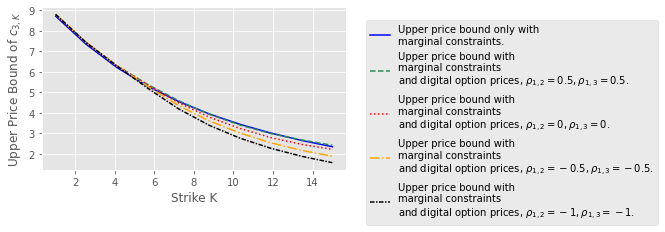

In [18]:
# Plot the lines
style.use('ggplot')
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(1, 2, 1)
ax.plot(grid_strikes,prices_FH,label="Upper price bound only with \nmarginal constraints.",color = "blue",linestyle='solid')
ax.plot(grid_strikes,prices_improved,label="Upper price bound with \nmarginal constraints \nand digital option prices, "+r'$\rho_{1,2}= 0.5,\rho_{1,3}= 0.5$.',color = "seagreen",linestyle='dashed')
ax.plot(grid_strikes,prices_improved_2,label="Upper price bound with \nmarginal constraints \nand digital option prices, "+r'$\rho_{1,2}= 0,\rho_{1,3}= 0$.',color = "red",linestyle='dotted')
ax.plot(grid_strikes,prices_improved_3,label="Upper price bound with \nmarginal constraints \nand digital option prices, "+r'$\rho_{1,2}= -0.5,\rho_{1,3}= -0.5$.',color = "orange",linestyle='dashdot')
ax.plot(grid_strikes,prices_improved_4,label="Upper price bound with \nmarginal constraints \nand digital option prices, "+r'$\rho_{1,2}= -1,\rho_{1,3}= -1$.',color = "black",linestyle=(0, (3, 1, 1, 1)))

# Adjust the plot
ax.set_xlabel("Strike K")
ax.set_ylabel("Upper Price Bound of "+ r"$c_{3,K}$")
ax.legend(bbox_to_anchor=(1.05, 0.95), loc='best')
plt.savefig('eps/exa_43_improvement.eps', format='eps')
plt.show()

The same, but focus on the (liquid) strikes between 8 and 12

In [20]:
#Set the grid
grid_strikes_zoom=np.linspace(8,12,10)
# Compute Price Bounds
prices_FH_zoom =[upper_bound_FH(K) for K in grid_strikes_zoom]
prices_improved_zoom = [upper_bound_improved(K,pi_12,pi_13,strikes) for K in grid_strikes_zoom]
prices_improved_2_zoom = [upper_bound_improved(K,pi_12_2,pi_13_2,strikes) for K in grid_strikes_zoom]
prices_improved_3_zoom = [upper_bound_improved(K,pi_12_3,pi_13_3,strikes) for K in grid_strikes_zoom]
prices_improved_4_zoom = [upper_bound_improved(K,pi_12_4,pi_13_4,strikes) for K in grid_strikes_zoom]

We plot the results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


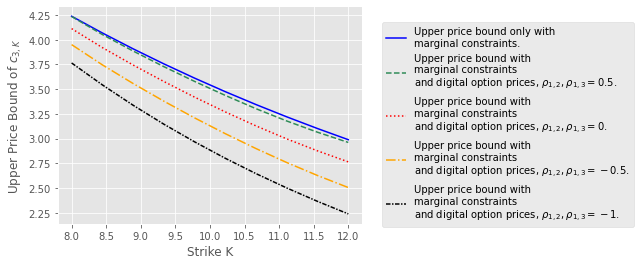

In [21]:
# Plot the lines
style.use('ggplot')
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(grid_strikes_zoom,prices_FH_zoom,label="Upper price bound only with \nmarginal constraints.",color = "blue",linestyle='solid')
ax.plot(grid_strikes_zoom,prices_improved_zoom,label="Upper price bound with \nmarginal constraints \nand digital option prices, "+r'$\rho_{1,2},\rho_{1,3}= 0.5$.',color = "seagreen",linestyle='dashed')
ax.plot(grid_strikes_zoom,prices_improved_2_zoom,label="Upper price bound with \nmarginal constraints \nand digital option prices, "+r'$\rho_{1,2},\rho_{1,3}= 0$.',color = "red",linestyle='dotted')
ax.plot(grid_strikes_zoom,prices_improved_3_zoom,label="Upper price bound with \nmarginal constraints \nand digital option prices, "+r'$\rho_{1,2},\rho_{1,3}= -0.5$.',color = "orange",linestyle='dashdot')
ax.plot(grid_strikes_zoom,prices_improved_4_zoom,label="Upper price bound with \nmarginal constraints \nand digital option prices, "+r'$\rho_{1,2},\rho_{1,3}= -1$.',color = "black",linestyle=(0, (3, 1, 1, 1)))

# Adjust the plot
ax.set_xlabel("Strike K")
ax.set_ylabel("Upper Price Bound of "+ r"$c_{3,K}$")
ax.legend(bbox_to_anchor=(1.05, 0.95), loc='best')
plt.savefig('eps/exa_43_improvement_zoom.eps', format='eps', bbox_inches='tight')
plt.show()

### Next, we aim at computing price bounds in dependence of price of digital option prices

Computation of the price bounds on a grid

In [38]:
# No of discretization Points (of the grid)
N = 10

# Initialize Grid
possible_prices_1 = np.linspace(0,1,N)
possible_prices_2 = np.linspace(0,1,N)
grid1_6 = np.zeros((N,N))
grid1_10 = np.zeros((N,N))

# Strikes of the digital options
strike_digital = 9


# define payoffs for fixed strikes
for i in range(N):
    for j in range(N):       
        copula_prices_var = [[possible_prices_1[i],possible_prices_2[j]]]
        try:
            grid1_6[i,j] = upper_bound_improved(6,[possible_prices_1[i]],[possible_prices_2[j]],[strike_digital])
            grid1_10[i,j] = upper_bound_improved(10,[possible_prices_1[i]],[possible_prices_2[j]],[strike_digital])
        except:
            pass

Plotting of the results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

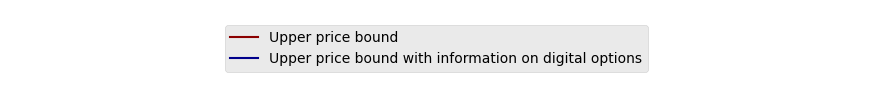

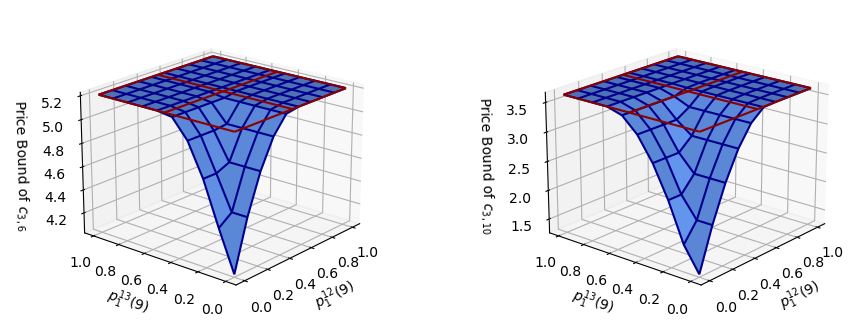

In [39]:
# LEGEND
first = [1]
second = [1]
third = [1]
style.use('ggplot')
plt.figure(figsize=(11,1))
plt.plot(first,linestyle='solid',color = "darkred")
plt.plot(second,linestyle='solid',color = "darkblue")
plt.plot(third,color = "cornflowerblue")
plt.legend(['Upper price bound', 
            'Upper price bound with information on digital options'],
           loc='center')
plt.axis('off')
plt.savefig('eps/continuous_copula_3d_legend.eps', format='eps', bbox_inches='tight')

# 3D PLOT
x = possible_prices_1
y = possible_prices_2
X, Y = np.meshgrid(x, y)

# creating a smaller grid to display the upper bounds
x_small = np.linspace(0,1,3)
y_small = np.linspace(0,1,3)
X_small, Y_small = np.meshgrid(x_small, y_small)

style.use('default')
fig = plt.figure(figsize=(11,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')


#ax.plot_wireframe(X_small, Y_small , np.ones((3,3))*np.max(np.max(grid1_9)),color = "darkblue")
ax.plot_wireframe(X_small, Y_small , np.ones((3,3))*np.max(np.max(grid1_6)),color = "darkred")
ax.plot_surface(X, Y , grid1_6,color = "cornflowerblue")
ax.plot_wireframe(X, Y , grid1_6,color = "darkblue")
ax.view_init(20,  220)
ax.set_xlabel(r'$p_1^{12}(9)$')
ax.set_ylabel(r'$p_1^{13}(9)$')
ax.set_zlabel("Price Bound of "+r"${c_{3,6}}$")

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_wireframe(X_small, Y_small , np.ones((3,3))*np.max(np.max(grid1_10)),color = "darkred")
ax.plot_surface(X, Y , grid1_10,color = "cornflowerblue")
ax.plot_wireframe(X, Y , grid1_10,color = "darkblue")
ax.view_init(20,  220)
ax.set_xlabel(r'$p_1^{12}(9)$')
ax.set_ylabel(r'$p_1^{13}(9)$')
ax.set_zlabel("Price Bound of "+r"${c_{3,10}}$")
# Save the plot
plt.savefig('eps/continuous_copula_3d.eps', format='eps', bbox_inches='tight')
plt.show()